In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow import keras
from keras import layers, Sequential
from keras.models import Model
from keras.layers import Input, Dense
from keras.optimizers import Adam, SGD, Adagrad, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras import initializers
from keras.optimizers import Adam
import os
from tensorflow.keras.preprocessing import image_dataset_from_directory
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
import matplotlib.pyplot as plt

2023-04-09 21:28:04.184185: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-09 21:28:05.202159: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-09 21:28:05.295897: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/piyush/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-04-09 21:28:

#### Reading the data, normalizing and flattening it

##### Reading and Normalizing

In [2]:

train = image_dataset_from_directory(
    'Group_24/train/',
    labels='inferred',
    label_mode='int',
    batch_size=1,
    image_size=(28, 28),
    shuffle=True,
    seed=42,
    color_mode='grayscale',
    validation_split=0.0
)

val = image_dataset_from_directory(
    'Group_24/val/',
    labels='inferred',
    label_mode='int',
    batch_size=1,
    image_size=(28, 28),
    shuffle=True,
    seed=42,
    color_mode='grayscale',
    validation_split=0.0
)

test = image_dataset_from_directory(
    'Group_24/test/',
    labels='inferred',
    label_mode='int',
    batch_size=1,
    image_size=(28, 28),
    shuffle=True,
    seed=42,
    color_mode='grayscale',
    validation_split=0.0
)

def normalize(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image, label

train = train.map(normalize)
val = val.map(normalize)
test = test.map(normalize)

Found 11385 files belonging to 5 classes.


2023-04-09 21:28:07.820477: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/piyush/.local/lib/python3.10/site-packages/cv2/../../lib64:
2023-04-09 21:28:07.820498: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-09 21:28:07.820510: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (piyush-HP-Spectre-x360-Convertible-13-aw2xxx): /proc/driver/nvidia/version does not exist
2023-04-09 21:28:07.820719: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other ope

Found 3795 files belonging to 5 classes.
Found 3795 files belonging to 5 classes.


##### Flattening

Preparing training tensors

In [3]:
# Iterate through the dataset and reshape each image tensor
image_tensors = []
label_tensors = []
for image, labels in train:
    num_images = image.shape[0]
    image_vectors = tf.reshape(image, [num_images, -1])
    image_tensors.append(image_vectors)
    label_tensors.append(labels)

# Concatenate the image tensors into a single tensor
train_vectors = [tf.concat(image_tensors, axis=0), tf.concat(label_tensors, axis=0)]

Preparing validation tensors

In [4]:
# Iterate through the dataset and reshape each image tensor
image_tensors = []
label_tensors = []
for image, labels in val:
    num_images = image.shape[0]
    image_vectors = tf.reshape(image, [num_images, -1])
    image_tensors.append(image_vectors)
    label_tensors.append(labels)

# Concatenate the image tensors into a single tensor
val_vectors = [tf.concat(image_tensors, axis=0), tf.concat(label_tensors, axis=0)]

Preparing testing tensors

In [5]:
# Iterate through the dataset and reshape each image tensor
image_tensors = []
label_tensors = []
for image, labels in test:
    num_images = image.shape[0]
    image_vectors = tf.reshape(image, [num_images, -1])
    image_tensors.append(image_vectors)
    label_tensors.append(labels)

# Concatenate the image tensors into a single tensor
test_vectors = [tf.concat(image_tensors, axis=0), tf.concat(label_tensors, axis=0)]

#### 1 Hidden layer autoencoder

In [6]:
initializer = initializers.RandomNormal(mean=0.0, stddev=0.05, seed=42)

model_history = dict()

print('Training 1 Hidden Layer autoencoder with different number of neurons in bottleneck layer')
for num_neurons in [32, 64, 128, 256]:
    print(f'1 Hidden Layer : {num_neurons} neurons')
    # define model
    model = Sequential([
        layers.Dense(784, activation="relu", input_shape=(784,)),
        layers.Dense(num_neurons, activation="sigmoid", name="hidden", 
                        kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
        layers.Dense(784, activation="relu", name="output", 
                        kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
    ])
    
    # compile model
    loss = tf.keras.losses.MeanSquaredError()
    adam_optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    model.compile(optimizer=adam_optimizer, loss=loss, metrics=['mse'])
    
    # callbacks
    my_callbacks = [
        EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5),
        TensorBoard(log_dir=f'./logdir/Q2/1_hidden_layer_{num_neurons}_neurons/')
    ]

    model_fit = model.fit(train_vectors[0].numpy(),train_vectors[0].numpy(), batch_size=len(train_vectors[0]), epochs=10000, verbose=0, callbacks=my_callbacks, 
                            validation_split=0.0, validation_data=(val_vectors[0].numpy(), val_vectors[0].numpy()), shuffle=True, validation_batch_size=None)
    
    model_history[f'1_hidden_layer_{num_neurons}_neurons'] = model_fit.history['mse']
    
    hist_metric = 'mse'
    print(f'epochs: {len(model_fit.history[hist_metric])}, mse: {model_fit.history[hist_metric][-1]}\n')
    model.save(f'models/Q2/1_hidden_layer_{num_neurons}_neurons.tf')



Training 1 Hidden Layer autoencoder with different number of neurons in bottleneck layer
1 Hidden Layer : 32 neurons
epochs: 400, mse: 0.021301347762346268

1 Hidden Layer : 64 neurons
epochs: 303, mse: 0.0164023507386446

1 Hidden Layer : 128 neurons
epochs: 218, mse: 0.015397363342344761

1 Hidden Layer : 256 neurons
epochs: 192, mse: 0.01572316884994507



##### Displaying reconstructed image for training data

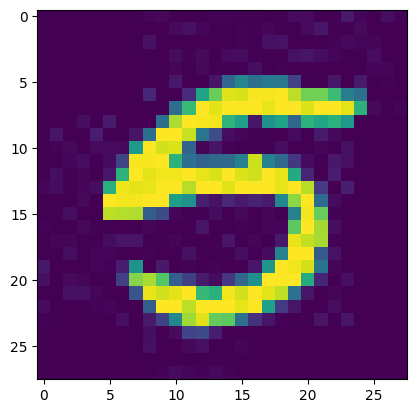

In [7]:
plt.imshow(train_vectors[0].numpy()[0].reshape(28,28))

1_hidden_layer_128_neurons.tf
1/1 [==============================] - 0s 191ms/step
1_hidden_layer_256_neurons.tf
1/1 [==============================] - 0s 65ms/step
1_hidden_layer_32_neurons.tf
1/1 [==============================] - 0s 62ms/step
1_hidden_layer_64_neurons.tf
1/1 [==============================] - 0s 60ms/step


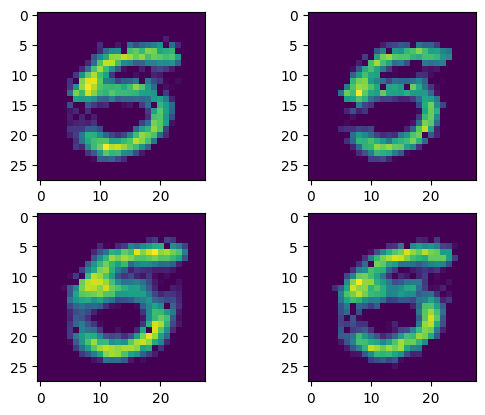

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=2)
ct = 0
for model in os.listdir("./models/Q2"):
    # models = os.listdir('./models/Q1')
    model_path = os.path.join('./models/Q2', model)
    if(model[0]!='1') : break
    print(model)
    trained_model = tf.keras.models.load_model(model_path)
    predictions = trained_model.predict(train_vectors[0].numpy()[0].reshape(1,784))
    ax[int(ct/2)][int(ct%2)].imshow(predictions.reshape(28,28))
    ct += 1

##### Displaying reconstructed images for validation data

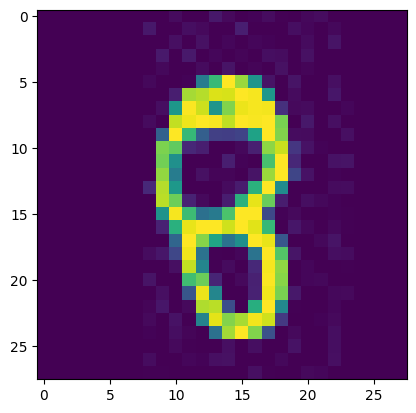

In [9]:
plt.imshow(val_vectors[0].numpy()[0].reshape(28,28))

1_hidden_layer_128_neurons.tf
1/1 [==============================] - 0s 59ms/step
1_hidden_layer_256_neurons.tf
1/1 [==============================] - 0s 53ms/step
1_hidden_layer_32_neurons.tf
1/1 [==============================] - 0s 51ms/step
1_hidden_layer_64_neurons.tf
1/1 [==============================] - 0s 63ms/step


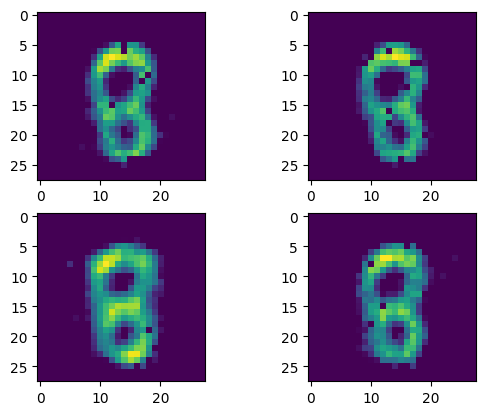

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=2)
ct = 0
for model in os.listdir("./models/Q2"):
    # models = os.listdir('./models/Q1')
    model_path = os.path.join('./models/Q2', model)
    if(model[0]!='1') : break
    print(model)
    trained_model = tf.keras.models.load_model(model_path)
    predictions = trained_model.predict(val_vectors[0].numpy()[0].reshape(1,784))
    ax[int(ct/2)][int(ct%2)].imshow(predictions.reshape(28,28))
    ct += 1

##### Displaying reconstructed images for testing data

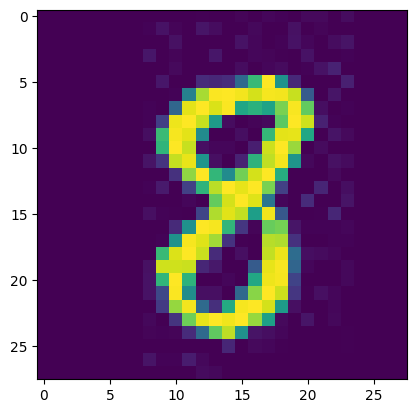

In [11]:
plt.imshow(test_vectors[0].numpy()[0].reshape(28,28))

1_hidden_layer_128_neurons.tf
1/1 [==============================] - 0s 58ms/step
1_hidden_layer_256_neurons.tf
1/1 [==============================] - 0s 53ms/step
1_hidden_layer_32_neurons.tf
1/1 [==============================] - 0s 49ms/step
1_hidden_layer_64_neurons.tf
1/1 [==============================] - 0s 56ms/step


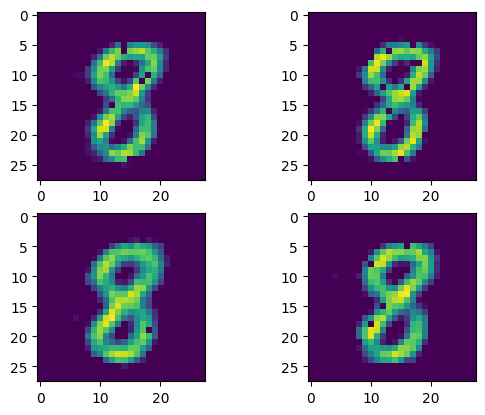

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=2)
ct = 0
for model in os.listdir("./models/Q2"):
    # models = os.listdir('./models/Q1')
    model_path = os.path.join('./models/Q2', model)
    if(model[0]!='1') : break
    print(model)
    trained_model = tf.keras.models.load_model(model_path)
    predictions = trained_model.predict(test_vectors[0].numpy()[0].reshape(1,784))
    ax[int(ct/2)][int(ct%2)].imshow(predictions.reshape(28,28))
    ct += 1

#### 3 Hidden layer autoencoder

In [13]:
initializer = initializers.RandomNormal(mean=0.0, stddev=0.05, seed=42)

model_history = dict()

print('Training 3 Hidden Layer autoencoder with different number of neurons in bottleneck layer')
for num_neurons in [32, 64, 128, 256]:
    print(f'1 Hidden Layer : {num_neurons} neurons')
    # define model
    model = Sequential([
        layers.Dense(784, activation="relu", input_shape=(784,)),
        layers.Dense(400, activation="sigmoid", name="hidden1", 
                        kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
        layers.Dense(num_neurons, activation="sigmoid", name="bottleneck", 
                        kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
        layers.Dense(400, activation="sigmoid", name="hidden3", 
                        kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
        layers.Dense(784, activation="relu", name="output", 
                        kernel_initializer=initializer, bias_initializer=initializers.Zeros()),
    ])
    
    # compile model
    loss = tf.keras.losses.MeanSquaredError()
    adam_optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
    model.compile(optimizer=adam_optimizer, loss=loss, metrics=['mse'])
    
    # callbacks
    my_callbacks = [
        EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=5),
        TensorBoard(log_dir=f'./logdir/Q2/3_hidden_layer_{num_neurons}_neurons/')
    ]

    model_fit = model.fit(train_vectors[0].numpy(),train_vectors[0].numpy(), batch_size=len(train_vectors[0]), epochs=10000, verbose=0, callbacks=my_callbacks, 
                            validation_split=0.0, validation_data=(val_vectors[0].numpy(), val_vectors[0].numpy()), shuffle=True, validation_batch_size=None)
    
    model_history[f'3_hidden_layer_{num_neurons}_neurons'] = model_fit.history['mse']
    
    hist_metric = 'mse'
    print(f'epochs: {len(model_fit.history[hist_metric])}, mse: {model_fit.history[hist_metric][-1]}\n')
    model.save(f'models/Q2/3_hidden_layer_{num_neurons}_neurons.tf')



Training 3 Hidden Layer autoencoder with different number of neurons in bottleneck layer
1 Hidden Layer : 32 neurons


KeyboardInterrupt: 

##### Displaying reconstructed image for training data

In [ ]:
plt.imshow(train_vectors[0].numpy()[0].reshape(28,28))
fig, ax = plt.subplots(nrows=2, ncols=2)
ct = 0
for model in os.listdir("./models/Q2"):
    # models = os.listdir('./models/Q1')
    model_path = os.path.join('./models/Q2', model)
    if(model[0]!='3') : break
    print(model)
    trained_model = tf.keras.models.load_model(model_path)
    predictions = trained_model.predict(train_vectors[0].numpy()[0].reshape(1,784))
    ax[int(ct/2)][int(ct%2)].imshow(predictions.reshape(28,28))
    ct += 1

##### Displaying reconstructed image for validation data

In [ ]:
plt.imshow(val_vectors[0].numpy()[0].reshape(28,28))
fig, ax = plt.subplots(nrows=2, ncols=2)
ct = 0
for model in os.listdir("./models/Q2"):
    # models = os.listdir('./models/Q1')
    model_path = os.path.join('./models/Q2', model)
    if(model[0]!='3') : break
    print(model)
    trained_model = tf.keras.models.load_model(model_path)
    predictions = trained_model.predict(val_vectors[0].numpy()[0].reshape(1,784))
    ax[int(ct/2)][int(ct%2)].imshow(predictions.reshape(28,28))
    ct += 1

##### Displaying reconstructed image for testing data

In [ ]:
plt.imshow(test_vectors[0].numpy()[0].reshape(28,28))
fig, ax = plt.subplots(nrows=2, ncols=2)
ct = 0
for model in os.listdir("./models/Q2"):
    # models = os.listdir('./models/Q1')
    model_path = os.path.join('./models/Q2', model)
    if(model[0]!='3') : break
    print(model)
    trained_model = tf.keras.models.load_model(model_path)
    predictions = trained_model.predict(test_vectors[0].numpy()[0].reshape(1,784))
    ax[int(ct/2)][int(ct%2)].imshow(predictions.reshape(28,28))
    ct += 1